In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

init_notebook_mode(connected=True)

In [2]:
file_name = "data_encoded_all.csv"
encoded_data = pd.read_csv(file_name)

In [3]:
y = encoded_data.pop('Recently Sold Price')
X = encoded_data

In [4]:
print(X.shape)
X.columns

(338, 11)


Index(['apple-iphone-6s', 'apple-iphone-6s-plus', 'apple-iphone-7-a1660',
       'apple-iphone-8-a1863', 'apple-iphone-8-plus-a1864', 'apple-iphone-se',
       'apple-iphone-x-a1865', 'Fair', 'Good', 'New (Resale)', 'Size'],
      dtype='object')

# Model Selection Process

Test: Trying polynomials up to **degree two**

Result: **No obvious improvement**

In [5]:
#Added after model selection process was completed
#Removes large warning lists
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [6]:
degree = 2
alphas = [0.2, 0.4, 0.6, 0.8, 1]
for alpha in alphas:
    est = make_pipeline(PolynomialFeatures(degree), linear_model.Lasso(alpha=alpha))
    #est.fit(X_train, y_train) 
    scores = cross_val_score(est, X, y, cv=5, scoring='neg_mean_squared_error')
    #print([round((-s)**0.5,2) for s in scores])
    print ('cv sqrt(mse) score is:', round(float(-sum(scores)/len(scores))**0.5,2))

cv sqrt(mse) score is: 34.7
cv sqrt(mse) score is: 38.88
cv sqrt(mse) score is: 41.21
cv sqrt(mse) score is: 42.59
cv sqrt(mse) score is: 43.73


Test: Try different values for **alpha** and **l1_ratio** in Elastic Net.

Result: There was a slight, but noticable improvement in rmse when **alpha = 0.15** and model is in pure **Lasso**.

In [7]:
for alpha in [0.2,0.4,0.8,1]:
        for l1_ratio in [0,.5,0.75,0.8,0.9,1]:
            regr_test = linear_model.ElasticNet(alpha=alpha,l1_ratio=l1_ratio)
            scores = cross_val_score(regr_test, X, y, cv=5, scoring='neg_mean_squared_error')
            #print([round((-s)**0.5,2) for s in scores])
            print ('cv sqrt(mse) score is:', round(float(-sum(scores)/len(scores))**0.5,2),'alpha',alpha,'l1_ratio',l1_ratio)

cv sqrt(mse) score is: 107.79 alpha 0.2 l1_ratio 0
cv sqrt(mse) score is: 83.9 alpha 0.2 l1_ratio 0.5
cv sqrt(mse) score is: 61.82 alpha 0.2 l1_ratio 0.75
cv sqrt(mse) score is: 55.94 alpha 0.2 l1_ratio 0.8
cv sqrt(mse) score is: 42.7 alpha 0.2 l1_ratio 0.9
cv sqrt(mse) score is: 32.53 alpha 0.2 l1_ratio 1
cv sqrt(mse) score is: 128.77 alpha 0.4 l1_ratio 0
cv sqrt(mse) score is: 108.36 alpha 0.4 l1_ratio 0.5
cv sqrt(mse) score is: 84.72 alpha 0.4 l1_ratio 0.75
cv sqrt(mse) score is: 77.22 alpha 0.4 l1_ratio 0.8
cv sqrt(mse) score is: 56.99 alpha 0.4 l1_ratio 0.9
cv sqrt(mse) score is: 32.97 alpha 0.4 l1_ratio 1
cv sqrt(mse) score is: 143.93 alpha 0.8 l1_ratio 0
cv sqrt(mse) score is: 129.5 alpha 0.8 l1_ratio 0.5
cv sqrt(mse) score is: 109.51 alpha 0.8 l1_ratio 0.75
cv sqrt(mse) score is: 102.21 alpha 0.8 l1_ratio 0.8
cv sqrt(mse) score is: 79.03 alpha 0.8 l1_ratio 0.9
cv sqrt(mse) score is: 33.87 alpha 0.8 l1_ratio 1
cv sqrt(mse) score is: 147.56 alpha 1 l1_ratio 0
cv sqrt(mse) score i

# Final Selected Model

Final Implementation and validation of the best model according to testing above.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

regr = linear_model.Lasso(alpha=0.17)

# Train the model using the training set
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

#The coefficients
# print('Coefficients: \n', regr.coef_)
#The mean squared error
print("Root mean standard error: %.2f$"
      % mean_squared_error(y_test, y_pred)**0.5)

# Explained variance score: 1 is a perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred))

scores = cross_val_score(regr, X, y, cv=5, scoring='neg_mean_squared_error')
print (f'Cross Val RMSE score is: {round(float(-sum(scores)/len(scores))**0.5,2)}$')

Root mean standard error: 34.28$
R2 score: 0.97
Cross Val RMSE score is: 32.47$


# Visualizing Performance Of The Model

Plotting the expected targets vs the predicted targets in the model. Ideally, they are exact and the points lie on the black line

In [9]:
trace1 = go.Scatter(
        x=y_pred,
        y=y_test,
        mode='markers',
        name = 'Test Data Targets'
        )
trace2 = go.Scatter(
        x=y_train_pred,
        y=y_train,
        mode='markers',
        name = 'Training Data Targets'
        )

layout = {
    
    'title':'Prediction Performance',
    'xaxis' : dict(title = 'Actual Value'),
    'yaxis' : dict(title = 'Predicted Value'),
    'shapes': [
        {
            'type': 'line',
            'x0': 0,
            'y0': 0,
            'x1': 900,
            'y1': 900,
            'line': {
                'color': 'rgb(0,0,0)',
                'width': 4
            },
        }
    ],
    'showlegend': True
}
data = [trace1,trace2]

iplot({'data':data, 'layout':layout},filename='basic')

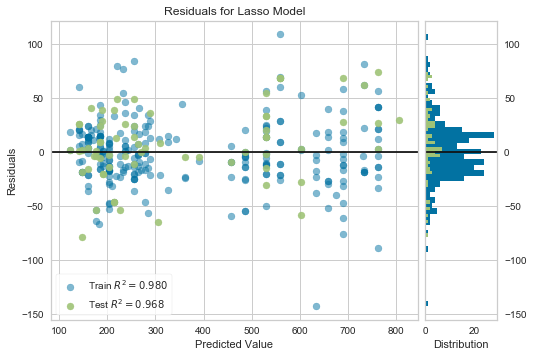

In [10]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(regr)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof() 

Strange bimodal distribution in residuals, need to check if the residuals are normally distributed

In [11]:
y_test = list(y_test)
y_train = list(y_train)
residual_data = []
for n in range(len(y_pred)):
    residual_data.append((y_pred[n]-y_test[n])**2)
for n in range(len(y_train)):
    residual_data.append((y_train[n]-y_train_pred[n])**2)
residual_data =np.array(residual_data)

In [12]:
from scipy import stats
k2, p = stats.normaltest(residual_data)
print('k2: ',k2, 'p: ',p)

k2:  387.8686737362363 p:  5.961940625452257e-85


Looks Normal!

In [13]:
X.columns

Index(['apple-iphone-6s', 'apple-iphone-6s-plus', 'apple-iphone-7-a1660',
       'apple-iphone-8-a1863', 'apple-iphone-8-plus-a1864', 'apple-iphone-se',
       'apple-iphone-x-a1865', 'Fair', 'Good', 'New (Resale)', 'Size'],
      dtype='object')

In [14]:
coef = list(zip(list(X.columns),list(regr.coef_)))  
coef.append(('Intercept',regr.intercept_))
coef

[('apple-iphone-6s', -133.97225138938163),
 ('apple-iphone-6s-plus', -81.96155184874543),
 ('apple-iphone-7-a1660', -35.617664188990446),
 ('apple-iphone-8-a1863', 119.70128697171991),
 ('apple-iphone-8-plus-a1864', 193.0859410466528),
 ('apple-iphone-se', -177.29690268808466),
 ('apple-iphone-x-a1865', 322.32796395931126),
 ('Fair', -47.8812151455427),
 ('Good', -29.560815868241153),
 ('New (Resale)', 42.93772540386337),
 ('Size', 0.38229169466426266),
 ('Intercept', 341.67623491162226)]

In [15]:
from sklearn.externals import joblib
joblib.dump(regr, 'swappa_lr_model.pkl')

['swappa_lr_model.pkl']

# Function For Real Time Prediction

In [16]:
mlb_model = pickle.load(open('mlb_model.sav', 'rb'))
mlb_condition = pickle.load(open('mlb_condition.sav', 'rb'))

In [17]:
print(mlb_model.classes_)
print(mlb_condition.classes_)

['apple-iphone-6s' 'apple-iphone-6s-plus' 'apple-iphone-7-a1660'
 'apple-iphone-7-plus-a1661' 'apple-iphone-8-a1863'
 'apple-iphone-8-plus-a1864' 'apple-iphone-se' 'apple-iphone-x-a1865']
['Fair' 'Good' 'Mint' 'New (Resale)']


In [18]:
def undo_mlb_transform(mlb, data_array):
    data_array = [[i] for i in data_array]
    undid = mlb.inverse_transform(np.transpose(data_array))
    return undid[0][0]
#print(undo_mlb_transformation(mlb_model,))

In [19]:
def predict_price(model,condition,size,coeff,intercept):
    test_vect = []
    
    if model == 'apple-iphone-7-plus-a1661':
        test_vect.extend(np.zeros(len(mlb_model.classes_)-1))
    else:
        model_list = mlb_model.transform([[model]])[0]
        print(model_list)
        test_vect.extend(np.delete(model_list,3))
        #test_vect.insert(3,0)
    print(len(test_vect))
    
    if condition == 'Mint':
        test_vect.extend(np.zeros(len(mlb_condition.classes_)-1))
    else:
        condition_list = mlb_condition.transform([[condition]])[0]
        test_vect.extend(np.delete(condition_list,2)) 
          
    test_vect.extend([size])
    
    pred_price = np.dot(regr.coef_, np.transpose(test_vect))

    return '$'+ str(round(pred_price+intercept,2))

In [38]:
predict_price('apple-iphone-7-plus-a1661','Mint',0,regr.coef_,regr.intercept_)

7


'$341.68'

# Experimenting With KNN Regression

Test: Saw a cool algorithm in "Introduction To Statistical Learning" called KNN.


Results: Performs very close to linear regression.

In [21]:
from sklearn.neighbors import KNeighborsRegressor

In [22]:
X_train_k = X_train
y_train_k = y_train
X_test_k = X_test
y_test_k = y_test

In [23]:
from sklearn.model_selection import GridSearchCV
neigh = KNeighborsRegressor()
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
model = GridSearchCV(neigh, params, cv=5)
model.fit(X,y)
model.best_params_

{'n_neighbors': 3}

In [24]:
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train_k, y_train_k) 
neigh.score(X_test_k,y_test_k)
y_pred_test_k = neigh.predict(X_test_k)
y_pred_train_k = neigh.predict(X_train_k)
scores = cross_val_score(neigh, X, y, cv=10, scoring='neg_mean_squared_error')
print ('cv sqrt(mse) score is:', round(float(-sum(scores)/len(scores))**0.5,2))

cv sqrt(mse) score is: 39.64


In [25]:
# Plot outputs

trace1 = go.Scatter(
        x=y_pred_test_k,
        y=y_test_k,
        mode='markers',
        name = 'Test data'
        )
trace2 = go.Scatter(
        x=y_pred_train_k,
        y=y_train_k,
        mode='markers',
        name = 'Test data'
        )

layout = {
    
    'title':'Prediction Performance',
    'xaxis' : dict(title = 'Actual Value'),
    'yaxis' : dict(title = 'Predicted Value'),
    'shapes': [
        {
            'type': 'line',
            'x0': 0,
            'y0': 0,
            'x1': 1000,
            'y1': 1000,
            'line': {
                'color': 'rgb(0,0,0)',
                'width': 4
            },
        }
    ],
    'showlegend': True
}
data = [trace1, trace2]

iplot({'data':data, 'layout':layout},filename='basic')


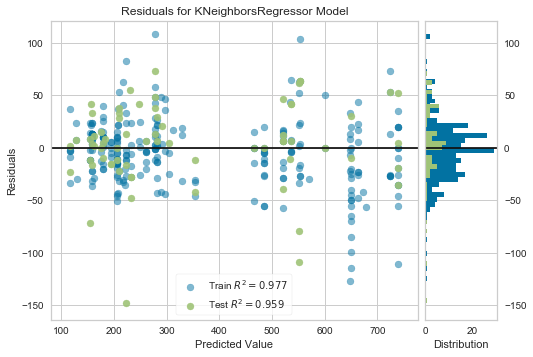

In [26]:
visualizer = ResidualsPlot(neigh)

visualizer.fit(X_train_k, y_train_k)  
visualizer.score(X_test_k, y_test_k)  
visualizer.poof() 

# 